<a href="https://colab.research.google.com/github/jumbokh/csu1112-class/blob/main/class/GuidedProject_DeepLearning_Regression_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression Deep Learning Problem
## Stock Price Prediction of Google

 https://www.kaggle.com/datasets/varpit94/google-stock-data?select=GOOGL.csv

DataSimple

 https://www.datasimple.education/

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# import data

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/brandynewanek/brandynewanek/main/GOOGL.csv')

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096
1,2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343
2,2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126
3,2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602


In [5]:
df.shape

(4431, 7)

# EDA

## palette

In [6]:
palette = ['#164B57', '#3DB37F']

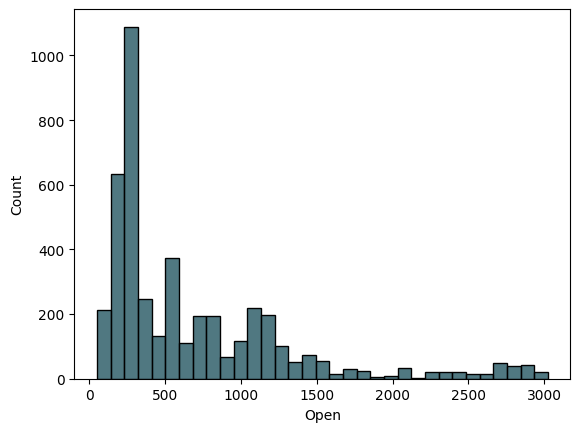

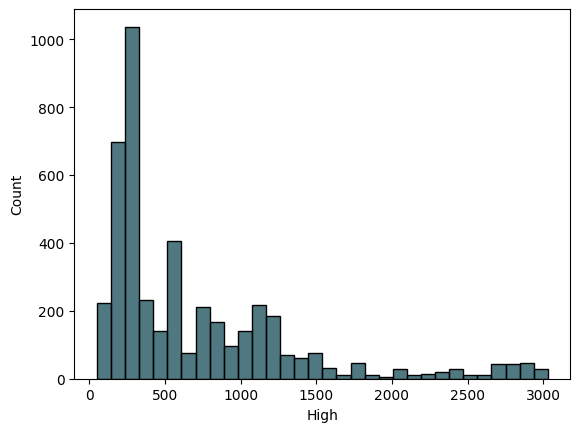

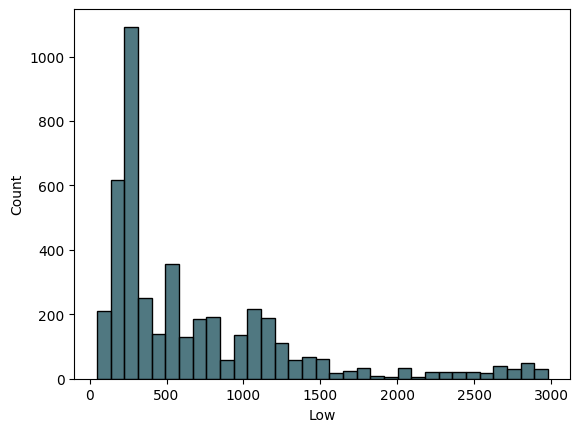

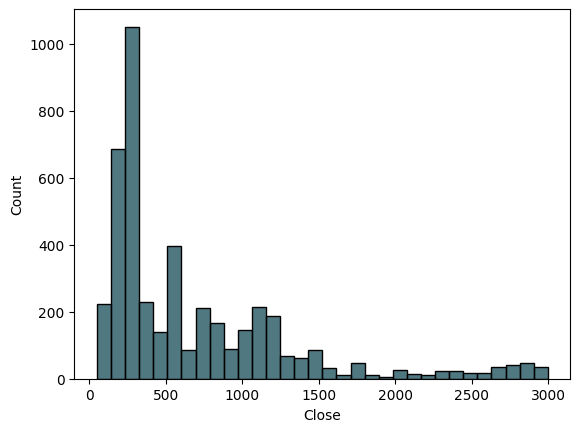

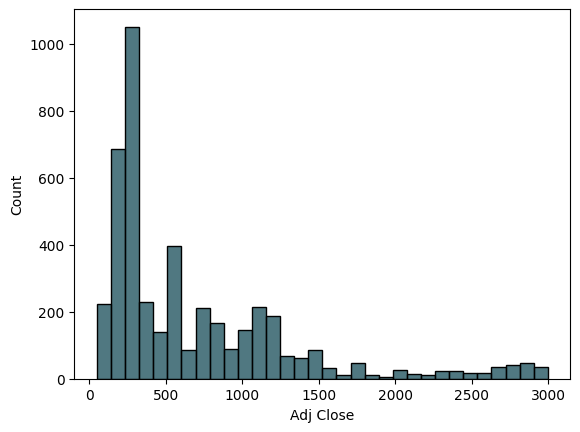

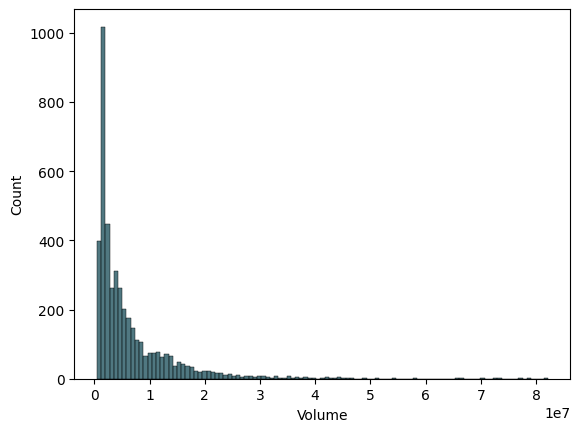

In [7]:
for feat in df.columns:
  if df[feat].dtype != 'object':
    sns.histplot(df, x=feat, color=palette[0])
    plt.show()

**Observations**

+ all distributions show exponential distribution

# Preprocessing

## Indicator Development

### MACD

In [8]:
df['ema_12'] = df['Close'].ewm(span=12).mean()
df['ema_26'] = df['Close'].ewm(span=26).mean()

In [9]:
df['macd_fast'] = df['ema_12'] - df['ema_26']

In [10]:
df['slow_macd'] = df['macd_fast'].ewm(span=9).mean()

In [11]:
df['macd'] = df['macd_fast'] - df['slow_macd']

### RSI

In [12]:
change = df['Close'].diff(1)
df['Gain'] = change.mask(change<0,0)
df['Loss'] = abs(change.mask(change>0,0))
df['AVG_Gain'] = df.Gain.rolling(14).mean()
df['AVG_Loss'] = df.Loss.rolling(14).mean()
df['RS'] = df['AVG_Gain']/df['AVG_Loss']
df['rsi'] = 100 - (100/(1+df['RS']))

## Visualize Indicators

array([[<Axes: >],
       [<Axes: >]], dtype=object)

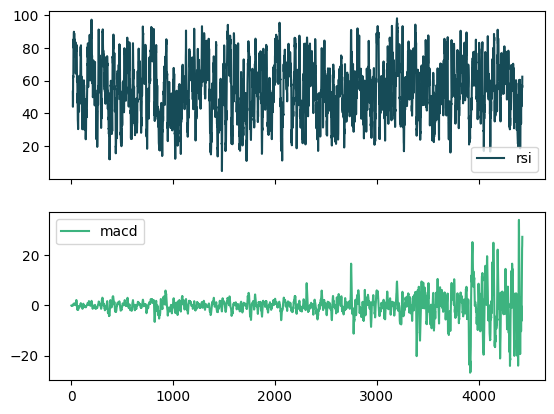

In [13]:
df[['rsi', 'macd']].plot(kind='line', color=palette, subplots=2, layout=(2,1))

## making target stationary 

In [14]:
df['Close_pct_chng'] = df['Close'].pct_change()

In [15]:
df.isnull().sum()

Date               0
Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
ema_12             0
ema_26             0
macd_fast          0
slow_macd          0
macd               0
Gain               1
Loss               1
AVG_Gain          14
AVG_Loss          14
RS                14
rsi               14
Close_pct_chng     1
dtype: int64

## Engineer Time Features

In [16]:
days_macd = [1,2,3,4,5,6,7,8,9,10]
days_rsi = [1,2,3,4,5,6,7,8,9,10]

In [17]:
for d in days_macd:
    df[f'macd_{d}_dyago'] = df['macd'].shift(d)

In [18]:
for d in days_rsi:
    df[f'rsi_{d}_dyago'] = df['rsi'].shift(d)

In [19]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ema_12,ema_26,macd_fast,...,rsi_1_dyago,rsi_2_dyago,rsi_3_dyago,rsi_4_dyago,rsi_5_dyago,rsi_6_dyago,rsi_7_dyago,rsi_8_dyago,rsi_9_dyago,rsi_10_dyago
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096,50.220219,50.220219,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343,52.380922,52.291425,0.089497,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126,53.307429,53.176475,0.130954,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337,53.048605,52.983864,0.064741,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602,53.049814,52.999910,0.049904,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df[['macd', 'macd_1_dyago']]

,macd,macd_1_dyago
0,0.000000,NaN
1,0.039776,0.000000
2,0.047941,0.039776
3,-0.012082,0.047941
4,-0.018911,-0.012082
...,...,...
4426,13.312184,7.243642
4427,16.659076,13.312184
4428,22.924694,16.659076
4429,23.799019,22.924694


## drop null

In [21]:
df = df.dropna()

# Modeling

## train test split

In [22]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'ema_12',
       'ema_26', 'macd_fast', 'slow_macd', 'macd', 'Gain', 'Loss', 'AVG_Gain',
       'AVG_Loss', 'RS', 'rsi', 'Close_pct_chng', 'macd_1_dyago',
       'macd_2_dyago', 'macd_3_dyago', 'macd_4_dyago', 'macd_5_dyago',
       'macd_6_dyago', 'macd_7_dyago', 'macd_8_dyago', 'macd_9_dyago',
       'macd_10_dyago', 'rsi_1_dyago', 'rsi_2_dyago', 'rsi_3_dyago',
       'rsi_4_dyago', 'rsi_5_dyago', 'rsi_6_dyago', 'rsi_7_dyago',
       'rsi_8_dyago', 'rsi_9_dyago', 'rsi_10_dyago'],
      dtype='object')

In [23]:
features = ['macd_1_dyago', 'macd_2_dyago', 'macd_3_dyago',
        'macd_4_dyago', 'macd_5_dyago', 'macd_6_dyago', 'macd_7_dyago',
        'macd_8_dyago', 'macd_9_dyago','macd_10_dyago',
        'rsi_1_dyago', 'rsi_2_dyago', 'rsi_3_dyago',
        'rsi_4_dyago', 'rsi_5_dyago', 'rsi_6_dyago', 'rsi_7_dyago',
        'rsi_8_dyago', 'rsi_9_dyago', 'rsi_10_dyago']
target = ['Close_pct_chng']

In [24]:
split_ind = 4000

In [25]:
df_tr = df.iloc[5:split_ind]
df_ts = df.iloc[split_ind:]

In [26]:
df_tr.isnull().sum()

Date              0
Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
ema_12            0
ema_26            0
macd_fast         0
slow_macd         0
macd              0
Gain              0
Loss              0
AVG_Gain          0
AVG_Loss          0
RS                0
rsi               0
Close_pct_chng    0
macd_1_dyago      0
macd_2_dyago      0
macd_3_dyago      0
macd_4_dyago      0
macd_5_dyago      0
macd_6_dyago      0
macd_7_dyago      0
macd_8_dyago      0
macd_9_dyago      0
macd_10_dyago     0
rsi_1_dyago       0
rsi_2_dyago       0
rsi_3_dyago       0
rsi_4_dyago       0
rsi_5_dyago       0
rsi_6_dyago       0
rsi_7_dyago       0
rsi_8_dyago       0
rsi_9_dyago       0
rsi_10_dyago      0
dtype: int64

In [27]:
x_tr = df_tr[features]
y_tr = df_tr[target]

x_ts = df_ts[features]
y_ts = df_ts[target]

In [28]:
print(x_tr.shape)
print(x_ts.shape)

(3995, 20)
(407, 20)


## standardize

In [29]:
std_scaler = StandardScaler().fit(x_tr)
x_tr = std_scaler.transform(x_tr)
x_ts = std_scaler.transform(x_ts)

In [30]:
dim = x_tr.shape[1]
dim

20

## architecture

In [31]:
dense_act = 'elu'
recur_act = 'tanh'
eps = 500
lrning_rt = .001
ls = 'mae'
opt = tf.keras.optimizers.SGD(learning_rate=lrning_rt)

In [32]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.LSTM(13, recurrent_activation=recur_act, input_shape=[dim,1]),
                                    tf.keras.layers.Dropout(.2),
                                    tf.keras.layers.Dense(16, activation=dense_act),
                                    tf.keras.layers.Dense(8, activation=dense_act),
                                    tf.keras.layers.Dropout(.2),
                                    tf.keras.layers.Dense(12, activation=dense_act),
                                    tf.keras.layers.Dense(1)
])
model.compile(loss=ls, optimizer=opt)#, metrics=['mse']

In [33]:
history = model.fit(x_tr, y_tr, 
          validation_split=.2,
          epochs=eps, batch_size=1024)

Epoch 1/500
4/4 [==============================] - 13s 612ms/step - loss: 0.0220 - val_loss: 0.0149
Epoch 2/500
4/4 [==============================] - 0s 44ms/step - loss: 0.0219 - val_loss: 0.0148
Epoch 3/500
4/4 [==============================] - 0s 38ms/step - loss: 0.0219 - val_loss: 0.0148
Epoch 4/500
4/4 [==============================] - 0s 39ms/step - loss: 0.0224 - val_loss: 0.0148
Epoch 5/500
4/4 [==============================] - 0s 40ms/step - loss: 0.0226 - val_loss: 0.0147
Epoch 6/500
4/4 [==============================] - 0s 41ms/step - loss: 0.0220 - val_loss: 0.0147
Epoch 7/500
4/4 [==============================] - 1s 295ms/step - loss: 0.0220 - val_loss: 0.0147
Epoch 8/500
4/4 [==============================] - 1s 317ms/step - loss: 0.0215 - val_loss: 0.0147
Epoch 9/500
4/4 [==============================] - 2s 610ms/step - loss: 0.0218 - val_loss: 0.0147
Epoch 10/500
4/4 [==============================] - 0s 146ms/step - loss: 0.0219 - val_loss: 0.0147
Epoch 11/500


<Axes: >

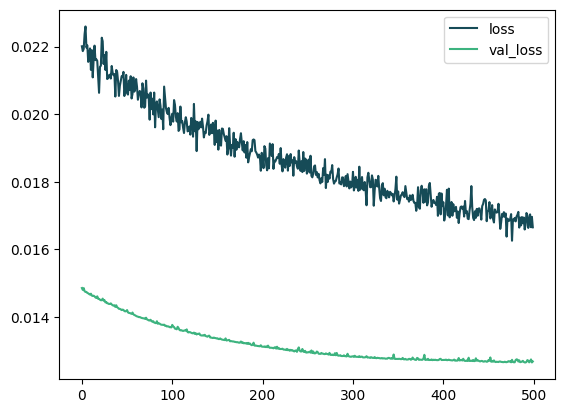

In [34]:
pd.DataFrame(history.history).plot(color=palette)

In [35]:
score = model.evaluate(x_ts, y_ts)

13/13 [==============================] - 0s 5ms/step - loss: 0.0152
